Iter 1/50 - Loss: 1.075
Iter 2/50 - Loss: 1.031
Iter 3/50 - Loss: 0.986
Iter 4/50 - Loss: 0.942
Iter 5/50 - Loss: 0.898
Iter 6/50 - Loss: 0.855
Iter 7/50 - Loss: 0.813
Iter 8/50 - Loss: 0.771
Iter 9/50 - Loss: 0.729
Iter 10/50 - Loss: 0.687
Iter 11/50 - Loss: 0.645
Iter 12/50 - Loss: 0.603
Iter 13/50 - Loss: 0.560
Iter 14/50 - Loss: 0.518
Iter 15/50 - Loss: 0.476
Iter 16/50 - Loss: 0.433
Iter 17/50 - Loss: 0.391
Iter 18/50 - Loss: 0.349
Iter 19/50 - Loss: 0.307
Iter 20/50 - Loss: 0.264
Iter 21/50 - Loss: 0.222
Iter 22/50 - Loss: 0.180
Iter 23/50 - Loss: 0.137
Iter 24/50 - Loss: 0.094
Iter 25/50 - Loss: 0.052
Iter 26/50 - Loss: 0.009
Iter 27/50 - Loss: -0.034
Iter 28/50 - Loss: -0.076
Iter 29/50 - Loss: -0.119
Iter 30/50 - Loss: -0.161
Iter 31/50 - Loss: -0.203
Iter 32/50 - Loss: -0.246
Iter 33/50 - Loss: -0.288
Iter 34/50 - Loss: -0.329
Iter 35/50 - Loss: -0.371
Iter 36/50 - Loss: -0.413
Iter 37/50 - Loss: -0.455
Iter 38/50 - Loss: -0.496
Iter 39/50 - Loss: -0.538
Iter 40/50 - Loss: -0

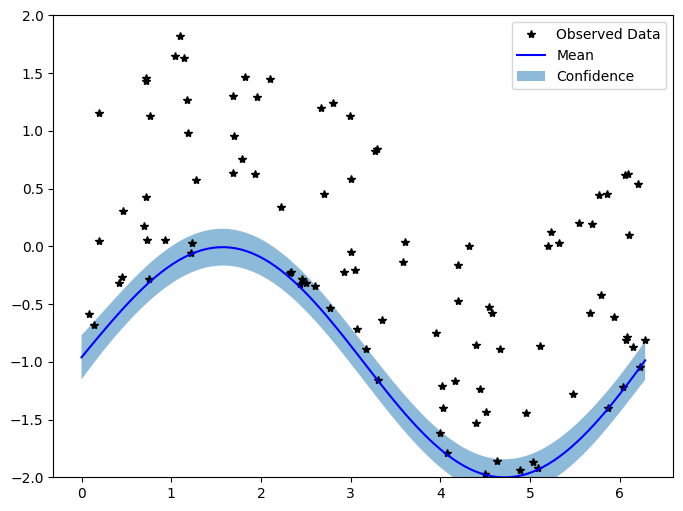

In [3]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

# Define a simple function to model
def true_function(x):
    return torch.sin(x[:, 0]) + torch.cos(x[:, 1])

# Generate training data
train_x = torch.rand(100, 2) * 2 * np.pi  # 100 points in the range [0, 2*pi)
train_y = true_function(train_x)

# Define the GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 50
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print(f'Iter {i+1}/{training_iterations} - Loss: {loss.item():.3f}')
    optimizer.step()

# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
test_x = torch.linspace(0, 2 * np.pi, 100)
test_x1 = torch.zeros(100, 2)
test_x1[:, 0] = test_x  # Vary the first input variable
test_x1[:, 1] = torch.tensor(np.pi)  # Fix the second input variable

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x1))

# Initialize plots
f, ax = plt.subplots(1, 1, figsize=(8, 6))

# Get mean and confidence intervals
mean = observed_pred.mean.numpy()
lower, upper = observed_pred.confidence_region()
lower = lower.numpy()
upper = upper.numpy()

# Plot training data as black stars
ax.plot(train_x[:, 0].numpy(), train_y.numpy(), 'k*')
# Plot predictive means as blue line
ax.plot(test_x.numpy(), mean, 'b')
# Shade between the lower and upper confidence bounds
ax.fill_between(test_x.numpy(), lower, upper, alpha=0.5)
ax.set_ylim([-2, 2])
ax.legend(['Observed Data', 'Mean', 'Confidence'])

plt.show()
